# LAB 8 : Time series analysis

In this lab, we are going to study the evolution of the food and fuel sales in French supermarkets between 2016 and 2020. 

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import itertools

import warnings
warnings.filterwarnings('ignore')

## Part A : Stationarity analysis of a gaussian white noise series

In this exercise, you will get familiar with some of the tools needed to analyze if a time series is stationnary or not. To do so, we will use a series made of white noise to which you will apply several statistical tests which obviously should conclude that a time series made of white noise is stationnary.

#### Question 1 : Generate a gaussian white noise series containing 1000 samples. You may use the *random.normal* command from the numpy library.

In [33]:
x = np.random.normal(0, 1, size=1000)

#### Quesiton 2 : Plot the signal. Does it look visually stationary? Explain why.

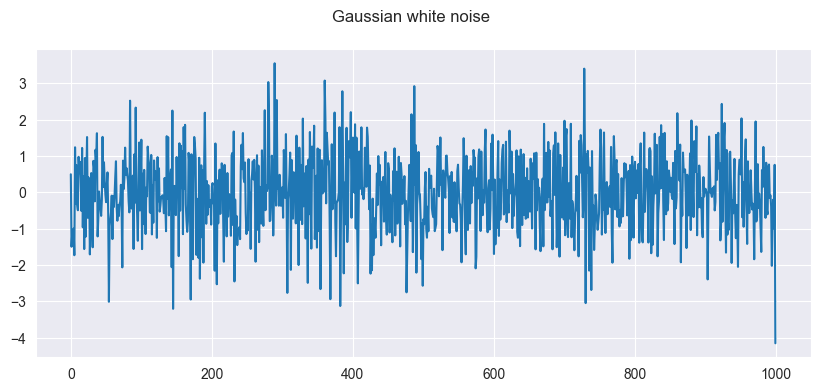

In [34]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x);
fig.suptitle('Gaussian white noise');

<u>Answer 2 : </u>

It looks centered around 0 and looks visually stationnary.

#### Question 3 : Plot and describe the autocorrelation functions (ACF) and partial autocorrelation functions (PACF) of this series. You may use the code below: 

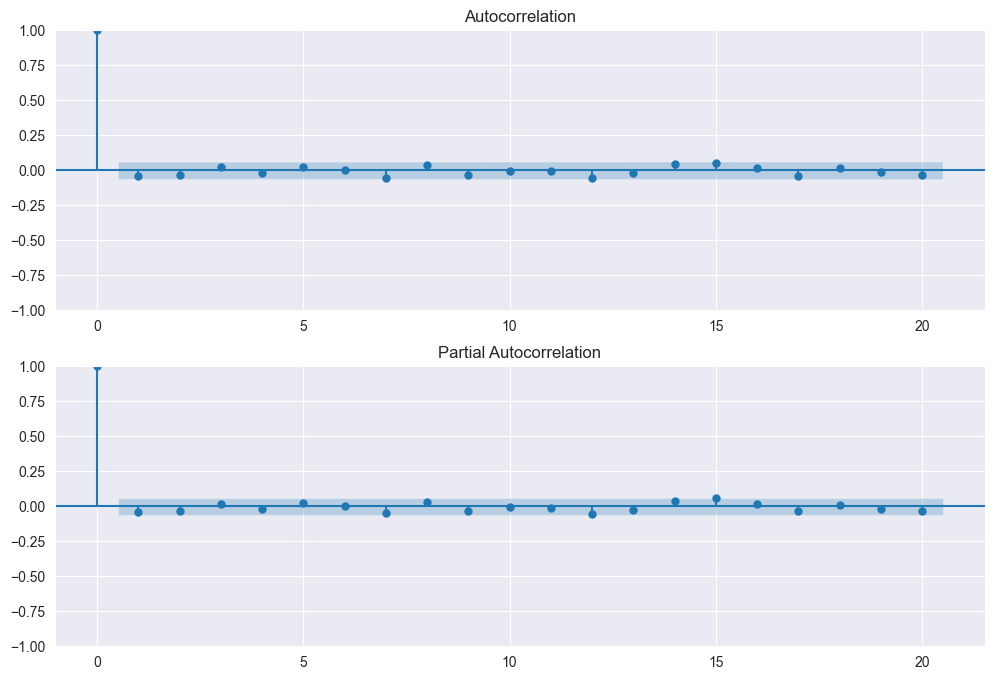

In [35]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(x, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(x, lags=20, ax=ax2)

#### Question 4 : Apply an Augmented Dickey Fuller (ADF) and Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test on the series. Explain what these tests do, and using both results, conclude on whether or not the series is indeed stationnary. 

Remark : You are strongly encouraged to look at the associated tutorial on the statsmodels webpage.

<u>Answer 4 : </u>
The ADF tests for the presence of a unit root (H0: there is a unit root, H1: it is stationnary or trend stationnary)
The KPSS tests the opposite (H0: it is stationnary)

In [36]:
#Create a function to check stationarity according to ADF and KPSS tests
def stationarity_tests(arr):
    
    #Check the stationarity of the the input series using the ADF test
    p_val = adfuller(arr)[1]
    
    #Threshold th ep-value
    if p_val <= 0.05:
        sign = '<='
        adf_stat = True
    else:
        sign = '>'
        adf_stat = False
    print('ADF: p-value = {0} {1} 0.05'.format(p_val, sign));

    #Check the stationarity of the input series using the KPSS test
    p_val = kpss(arr, nlags='auto')[1]

    
    #Threshold th ep-value
    if p_val <= 0.05:
        sign = '<='
        kpss_stat = False
    else:
        sign = '>'
        kpss_stat = True
    print('KPSS: p-value = {0} {1} 0.05'.format(p_val, sign));

    #Conclusion on stationarity
    if adf_stat and kpss_stat:
        stat_status = ''
    if not adf_stat and not kpss_stat:
        stat_status = 'non'
    if adf_stat and not kpss_stat:
        stat_status = 'difference'
    if not adf_stat and kpss_stat:
        stat_status = 'trend'
    
    print('The series is {0} stationary.'.format(stat_status))
    
    return stat_status

In [37]:
stat_status = stationarity_tests(x)

ADF: p-value = 0.0 <= 0.05
KPSS: p-value = 0.1 > 0.05
The series is  stationary.


## Part B : Analysis of a real time series

We are going to study the stationarity of food and fuel sales in French supermarkets between 2016 and 2020. To that purpose, we will use two statistical tests: the Box-Pierce and the Shapiro Wilk tests.

### Section B.1 : Stationarity analysis

#### Question 1 : Recall chat the Box-Piercce and Shapiro-Wilk tests do

<u>Answer 1 : </u> 

Box-Pierce Test:
Purpose: The Box-Pierce test is used to assess whether a given time series exhibits autocorrelation at lag values up to a specified number of lags.
Null Hypothesis(H0): The time series has no autocorrelation of order 1 to R
Alternative Hypothesis (H1): There is some autocorrelation in the time series.
When to Use: The Box-Pierce test can be used on a time series to confirm that searching for autoregressive (AR) parameters is relevant. It can also be used on the residuals of a model to check whether the residuals have any autocorrelation.

Shapiro-Wilk Test:
Purpose: The Shapiro-Wilk test is used to assess whether a given sample of data follows a Gaussian (normal) distribution.
Null Hypothesis (H0): The time series or the sample follows a Gaussian distribution.
Alternative Hypothesis (H1): It does not follow a Gaussian distribution.
When to Use: The Shapiro-Wilk test can be used on a time series to confirm a Gaussian distribution. It can also be used on the residuals of a model to confirm that they follow a Gaussian distribution, which is a desirable property for the residuals to be considered white noise.

#### Question 2 : Load the sales.csv file using pandas.

In [38]:
df = pd.read_csv("Data/sales.csv", index_col=0)
df

,Food,Fuel,Notfood
2016-01,99.43,93.31,99.27
2016-02,99.88,93.85,99.90
2016-03,101.21,92.83,99.11
2016-04,96.78,92.33,100.12
2016-05,98.45,99.12,98.09
2016-06,98.92,91.80,98.03
2016-07,99.30,95.48,96.57
2016-08,100.52,95.08,97.59
2016-09,100.32,97.50,96.88
2016-10,100.51,100.56,96.88


#### Question 3 : Plot both time series between January 2016 and December 2019, and comment on their likely stationarity or non-stationarity.

In [39]:
#Save the food and fuel sales between 2016 and 2019 into an array
food_sales = df.loc['2016-01':'2019-12']['Food'].values
fuel_sales = df.loc['2016-01':'2019-12']['Fuel'].values

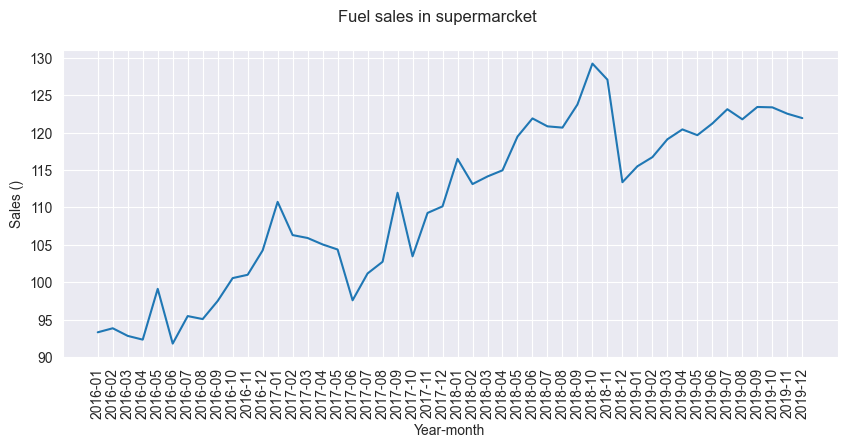

In [40]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df.loc['2016-01':'2019-12'].index, fuel_sales);
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('Sales ()')
ax.set_xlabel('Year-month')
fig.suptitle('Fuel sales in supermarcket');

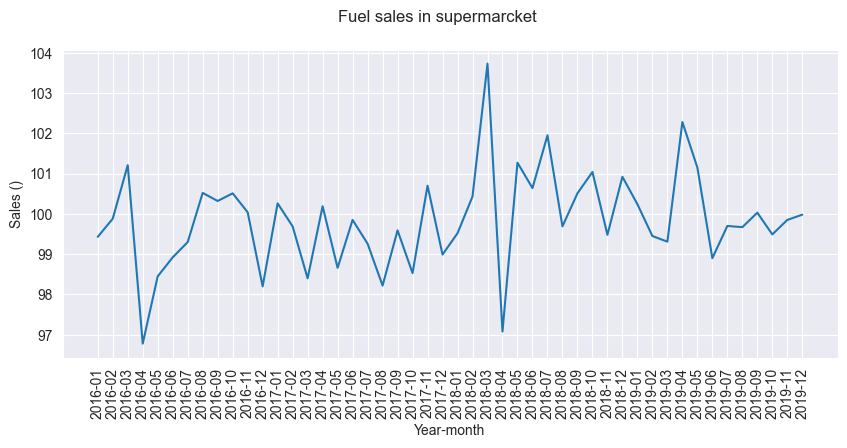

In [41]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df.loc['2016-01':'2019-12'].index, food_sales);
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('Sales ()')
ax.set_xlabel('Year-month')
fig.suptitle('Fuel sales in supermarcket');

<u>Answer 3 :</u>

From the visualisation we can predict that Fuel function is non-stationary, and that Food is stationary

#### Question 4 : Apply a Shapiro-Wilk (*stats.shapiro()*) and a Box-Pierce (*acorr_ljungbox* from *statsmodels.stats.diagnostic* with the correct parameters) tests on the supermarket food and fuel sales between January 2016 and December 2019. Based on your previous answer, can you conclude on the stationarity for each of these two series? If not, apply again question 2 to 4 from Part A.

In [42]:
for arr in [food_sales, fuel_sales]:
    r = sm.stats.acorr_ljungbox(arr, lags=[1],boxpierce=True,return_df=True);
    if r["bp_pvalue"][1] <= 0.05:
        sign = '<='
    else:
        sign = '>'
    print('p-value = {0} {1} 0.05'.format(r["bp_pvalue"][1], sign));

p-value = 0.414583300142219 > 0.05
p-value = 6.407540379506912e-10 <= 0.05


<u>Answer 4 (Box-Pierce results) :</u>

H0: the series has no auto-correlation
- Food sales : p value > 0.05, so H0 can not be rejected --> The food sales has no auto-correlation
- Fuel sales : p values <= 0.5 - there is evidence for rejecting H0 * --> The fuel sales have some auto-correlation
distribution

In [43]:
#Apply a Shapiro Wilk test on both series
for arr in [food_sales, fuel_sales]:
    _, spval = stats.shapiro(arr)
    if spval <= 0.05:
        sign2 = '<='
    else:
        sign2 = '>'
    spval = round(spval * 1000) / 1000
    print('p-value = {0} {1} 0.05'.format(spval, sign2));

p-value = 0.243 > 0.05
p-value = 0.01 <= 0.05


<u>Answer 4 (SW results) :</u>

H0: the series is drawn from a normal distribution
- Food sales : p value > 0.05, so H0 can not be rejected --> The food sales is drawn from a normal distribution
- Fuel sales : p values <= 0.5 - there is evidence for rejecting H0 * --> The fuel sales does not follow a Gaussian
distribution

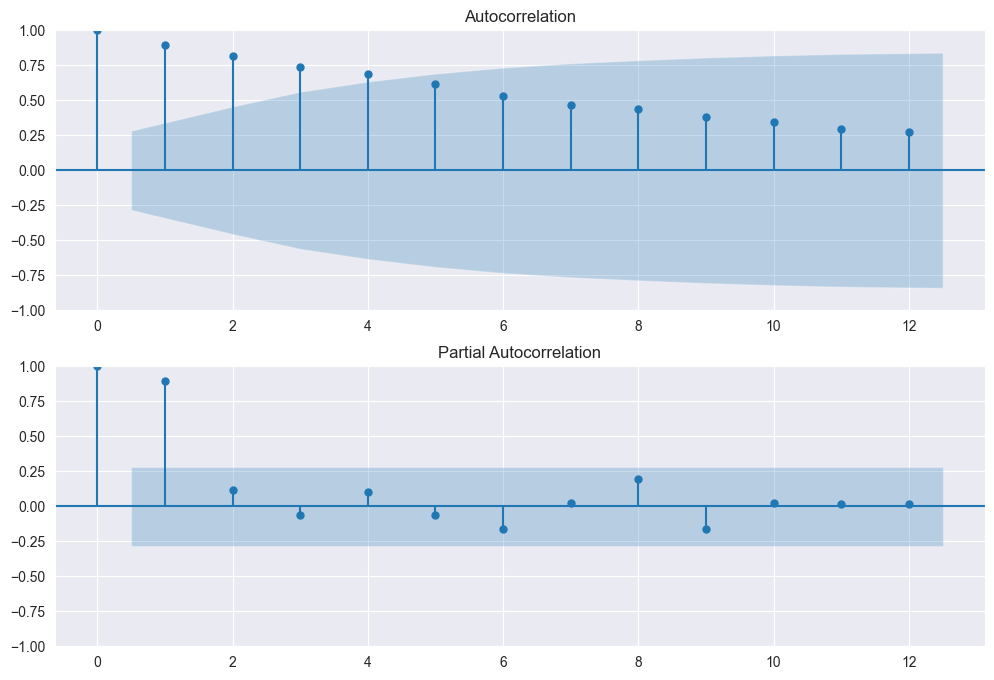

In [44]:
#ACF and PACF of fuel sales
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(fuel_sales, lags=12, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(fuel_sales, lags=12, ax=ax2)

<u>Answer 4 (ACF and PACF) :</u>

The ACF of a non-stationary time series decreases slowly. 
- The ACF of a nonstationary time series shows many values out of the confidence interval. 
- The first value of an ACF of a non-stationary time series is often large and positive. 

Thus, this time series does not look stationary according to its ACF/PACF plots

In [45]:
stat_status = stationarity_tests(fuel_sales)

ADF: p-value = 0.49206827344428 > 0.05
KPSS: p-value = 0.01 <= 0.05
The series is non stationary.


### Section B.2 : Influence of differencing on the stationarity


#### Question 5 : Differentiate the *non-stationary series* studied in section B.1, that is, create a new series that is the difference between the original observation and the observation at the previous time step.  Then plot the dfferentiated series. Does it look stationnary ?

In [46]:
fuel_diff=df.loc['2016-01':'2019-12']['Fuel'].diff().values
fuel_diff

array([   nan,   0.54,  -1.02,  -0.5 ,   6.79,  -7.32,   3.68,  -0.4 ,
         2.42,   3.06,   0.44,   3.26,   6.49,  -4.44,  -0.39,  -0.86,
        -0.68,  -6.79,   3.59,   1.56,   9.23,  -8.5 ,   5.8 ,   0.88,
         6.35,  -3.37,   1.02,   0.82,   4.51,   2.43,  -1.06,  -0.17,
         3.09,   5.47,  -2.15, -13.71,   2.13,   1.22,   2.39,   1.32,
        -0.77,   1.56,   1.91,  -1.35,   1.65,  -0.05,  -0.85,  -0.59])

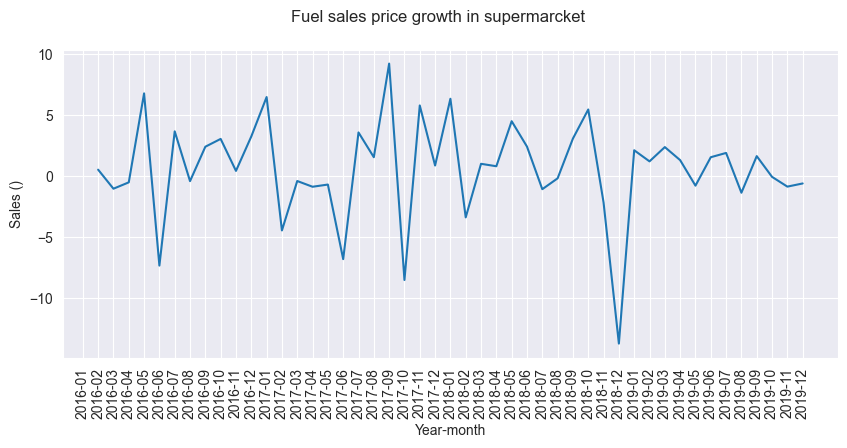

In [47]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df.loc['2016-01':'2019-12'].index, fuel_diff);
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('Sales ()')
ax.set_xlabel('Year-month')
fig.suptitle('Fuel sales price growth in supermarcket');

<u>Answer 5 : </u>

Visually, it could be stationnary. It looks somewhat centered around 0 and it could be white noise.
However, further test would be needed to confirm or infirm.

#### Question 6 : Plot and comment the ACF and PACF of the differentiated fuel series.

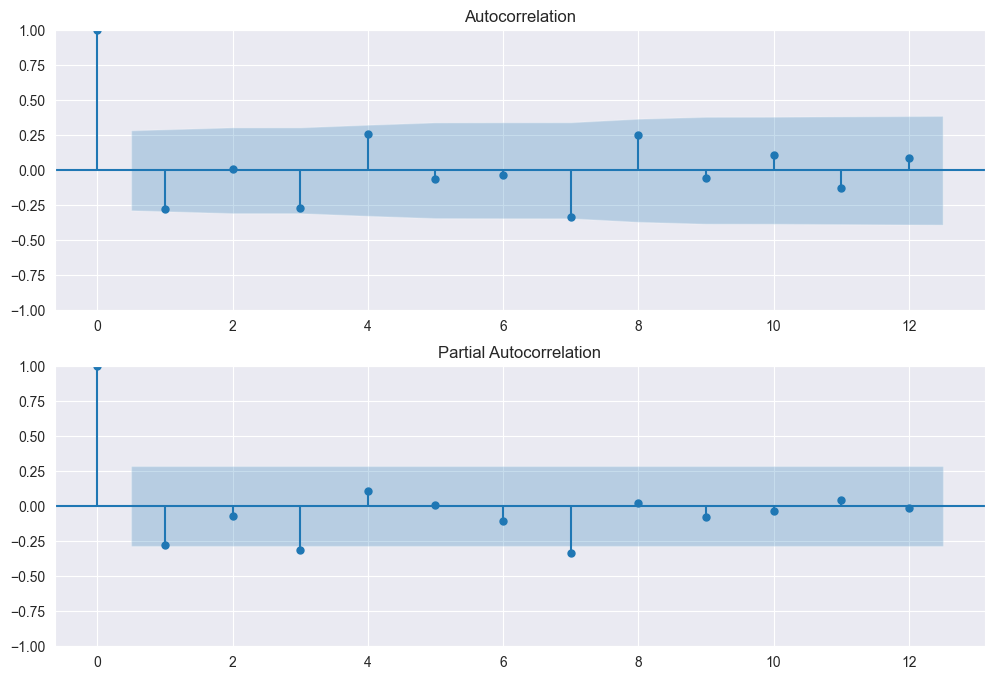

In [48]:
#the difference computed previously has a NaN vlaue which messes things up, so we do it again manually
fuel_sales_d = fuel_sales[1:] - fuel_sales[:len(fuel_sales) - 1]

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(fuel_sales_d, lags=12, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(fuel_sales_d, lags=12, ax=ax2)

#### Question 7 : Like in the previous exercises, apply both ADF and KPSS tests on the differentiated series. Conclude.

In [49]:
stat_status = stationarity_tests(fuel_sales_d)

ADF: p-value = 7.760535126212486e-07 <= 0.05
KPSS: p-value = 0.1 > 0.05
The series is  stationary.


<u>Answer 7 :</u>

This time series (fuel first derivative) appears to be stationnary

## Part C : ARIMA modelling

In this section, we are trying to fit an ARIMA(p,d,q) model for the fuel time series. Since we have already differentiated it once, we already have d which is equal to at least 1.

#### Question 1 : We will train the ARIMA model from 2016 to 2019 and test it on the 2020 part of the series. Split the original time series into training and test set accordingly.

In [50]:
train_start = '2016-01'
train_end = '2019-12'
test_start = '2020-01'
test_end = '2020-09'

#Define the training and test sets
x_train = df.loc[train_start:train_end]['Fuel'].values
x_test = df.loc[test_start:test_end]['Fuel'].values

#### Question 2 : Based on the PACF in question B.6 : propose several parameters to test for the possible ARIMA model of the previous time series. Then, evaluate them using the BIC and AIC criterion

In [51]:
# we will test d=1, p=0,1,7 and q=0,1, we know that the most likely is ARIMA(0,1,0)

x_preds = []
fitted_models = []

d=1
param_id=0
for (p,q) in list(itertools.product([0,1,7],[0,1])):
        print('\n p={0}, d={1} q={2}'.format(p, d, q))

        #Prepare the training of the ARMA model
        model = ARIMA(x_train, order=(p, d, q))

        #Train the ARMA model
        model_fit = model.fit()
        fitted_models.append(model_fit)

        #Test the model
        x_pred = model_fit.forecast(steps=len(x_test))[0]
        x_preds.append(x_pred)

        #Get useful metrics
        print('Standard error: {0}'.format(model_fit.bse[0]))
        print('Log-Likelihood function: {0}'.format(model_fit.llf))
        print('AIC score: {0}'.format(model_fit.aic))
        print('BIC score: {0}'.format(model_fit.bic))

        #Update the result vector
        x_preds.append(x_pred)

        #Best score
        if param_id == 0:
            best_bic = model_fit.bic
            best_aic = model_fit.aic
            best_p = p
            best_q = q
            param_id +=1
        elif model_fit.aic < best_aic and model_fit.bic < best_bic:
            best_bic = model_fit.bic
            best_aic = model_fit.aic
            best_p = p
            best_q = q
        param_id +=1
print('\n Best parameter values: (p,d, q) = ({0}, {1}, {2})'.format(best_p, d ,best_q))        


 p=0, d=1 q=0
Standard error: 2.6020812719585176
Log-Likelihood function: -133.18519899623988
AIC score: 268.37039799247975
BIC score: 270.2205455941898

 p=0, d=1 q=1
Standard error: 0.15974617636817054
Log-Likelihood function: -131.61282877420396
AIC score: 267.2256575484079
BIC score: 270.92595275182805

 p=1, d=1 q=0
Standard error: 0.16638493361886775
Log-Likelihood function: -131.7464031335863
AIC score: 267.4928062671726
BIC score: 271.19310147059275

 p=1, d=1 q=1
Standard error: 0.5866367831481061
Log-Likelihood function: -131.5692898809608
AIC score: 269.1385797619216
BIC score: 274.6890225670518

 p=7, d=1 q=0
Standard error: 0.1685079656778331
Log-Likelihood function: -127.90514243345258
AIC score: 271.81028486690514
BIC score: 286.61146568058564

 p=7, d=1 q=1
Standard error: 0.6891367079137557
Log-Likelihood function: -127.43277464855088
AIC score: 272.8655492971018
BIC score: 289.51687771249226

 Best parameter values: (p,d, q) = (0, 1, 0)


#### Question 3 : Test the residual of your proposed models to check that they are white noise.

In [52]:
d=1
param_id=0
for (p,q) in list(itertools.product([0,1,7],[0,1])):
    model_fit=fitted_models[param_id]
    
    #Box-Pierce test
    r = sm.stats.acorr_ljungbox(model_fit.resid, lags=12,boxpierce=True,return_df=True);
    bppval=round(r["bp_pvalue"][1] * 100000) /100000
    if bppval <= 0.05:
        sign1 = '<='
    else:
        sign1 = '>'

    #Shapiro Wilk test
    W, spval = stats.shapiro(model_fit.resid)
    if spval <= 0.05:
        sign2 = '<='
    else:
        sign2 = '>'
        spval = round(spval * 100000) / 100000

        #Display results
    print('p={0}, d={6}, q={1}: *Box-Pierce: p-value = {2}{3}0.05%' '\n *Shapiro-Wilk pvalue = {4}{5}0.05%\n'.format(p, q,bppval,sign1,spval,sign2,d))

p=0, d=1, q=0: *Box-Pierce: p-value = 0.86461>0.05%
 *Shapiro-Wilk pvalue = 4.329613775702717e-13<=0.05%

p=0, d=1, q=1: *Box-Pierce: p-value = 0.86461>0.05%
 *Shapiro-Wilk pvalue = 4.329613775702717e-13<=0.05%

p=1, d=1, q=0: *Box-Pierce: p-value = 0.86461>0.05%
 *Shapiro-Wilk pvalue = 4.329613775702717e-13<=0.05%

p=1, d=1, q=1: *Box-Pierce: p-value = 0.86461>0.05%
 *Shapiro-Wilk pvalue = 4.329613775702717e-13<=0.05%

p=7, d=1, q=0: *Box-Pierce: p-value = 0.86461>0.05%
 *Shapiro-Wilk pvalue = 4.329613775702717e-13<=0.05%

p=7, d=1, q=1: *Box-Pierce: p-value = 0.86461>0.05%
 *Shapiro-Wilk pvalue = 4.329613775702717e-13<=0.05%


<u>Answer 3 </u>

Unsurprisingly, all the residuals are indeed stationary.

#### Question 4 : Using your best model, project the original data and the ARIMA model for 2016-2019. Then, add year 2020 with the forcasted value of your ARIMA model. Comment.

In [53]:
model_fit = ARIMA(pd.Series(x_train), order=(1, 0, 1)).fit()

<Figure size 640x480 with 0 Axes>

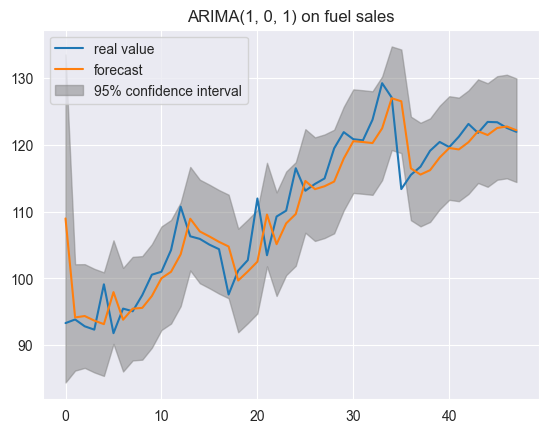

In [54]:
#Compare visually the predicted and true sale vales 2016-2019
plt.figure();
fig, ax = plt.subplots()
ax.plot(df.loc['2016-01':'2019-12']['Fuel'].values,label="real value");
plot_predict(model_fit,ax=ax);
plt.title("ARIMA(1, 0, 1) on fuel sales");
plt.legend();
plt.show();

<Figure size 640x480 with 0 Axes>

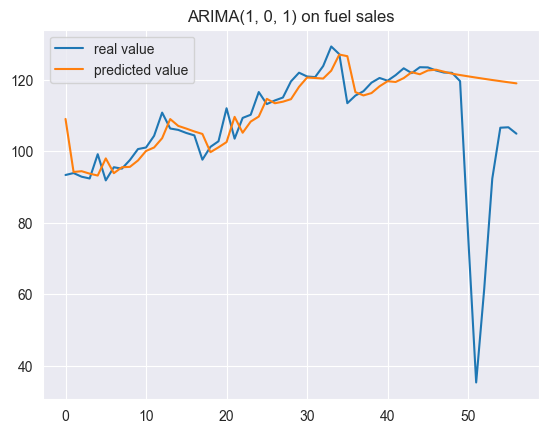

In [55]:
tot_pred=list(model_fit.predict())+list(model_fit.forecast(steps=len(x_test)))

#Compare visually the predicted and true sale vales 2016-2020
plt.figure();
fig, ax = plt.subplots()
ax.plot(df.loc['2016-01':'2020-12']['Fuel'].values,label="real value");
ax.plot(tot_pred,label="predicted value");
plt.title("ARIMA(1, 0, 1) on fuel sales");
plt.legend();
plt.show();